In [1]:
# kinetics package for doing the modelling
# Requires SALib and tqdm
import kinetics

# Imported from this directory
import species, reactions
from graph_settings import *
set_graph_settings()

# General packages used in this notebook
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
%matplotlib inline

# The Model

In [2]:
""" ------------------- SUBSTRATE AND ENZYME STARTING CONDITIONS  ------------------- """

# All species are initialised at 0 in species.py.
species = species.species_all

# Here the relevent species can be set to the correct levels
reaction_species = {"Ester": (2800, 0.05),
                    'afEst2': (10, 0.05),
                   }

# Set the species dictionaries required by the model
species.update(reaction_species)
species_defaults = kinetics.set_species_defaults(species)
species_bounds = kinetics.get_bounds_from_pc_error(species)

""" ------------------- PARAMETERS  ------------------- """

parameters_with_std_error = {}

# Parameter dictionaries are found in reactions.py
# They are added to the model parmaters variable 
parameters_with_std_error.update(reactions.esterase_params)

parameter_defaults = kinetics.set_parameter_defaults(parameters_with_std_error)
parameter_bounds = kinetics.get_bounds_from_std_error(parameters_with_std_error)

""" ------------------- MODEL TIME SETTINGS  ------------------- """
start = 0
end = 240
number_steps = 16

""" ------------------- MODEL  ------------------- """
model = kinetics.Model()
model.set_species_defaults(species_defaults)
model.set_parameter_defaults(parameter_defaults)
model.set_time(start, end, number_steps, mxsteps=10000)

# Add relevant reaction functions found in reaction.py
model.append(reactions.esterase_r1)

# Run the uncertainty analysis

In [3]:
ua = kinetics.UA(parameter_bounds,
                 species_bounds,
                 model,
                 num_samples=1000,
                 quartile_range=95)
ua.make_lhc_samples()
ua.run_models()
ua.calculate_quartiles()
ua.quartiles_to_dataframe();

substrates = ["Ester", "Acid"]
for s in substrates:
    display(Markdown("### -- " + str(s) + " --"))
    display(ua.substrate_dataframes[s])


running all models


100%|██████████| 1000/1000 [00:01<00:00, 649.42it/s]


samples run
quartiles calculated
saved as dataframes in a dict self.substrate_dataframes:  {"substrate" : dateframe}


### -- Ester --

,Time,High,Low,Mean
0,0.0,2925.738540,2674.014569,2799.997968
1,16.0,2356.230479,2047.693355,2200.933170
2,32.0,1869.853213,1461.699009,1662.876086
3,48.0,1437.099752,965.436317,1198.757723
4,64.0,1072.135641,585.471161,820.024109
5,80.0,768.084298,324.127120,531.825782
6,96.0,531.492996,165.596552,328.772122
7,112.0,353.734681,80.595645,195.696393
8,128.0,227.596264,38.240351,113.440419
9,144.0,143.018935,17.755096,64.680348


### -- Acid --

,Time,High,Low,Mean
0,0.0,0.000000,0.000000,0.000000
1,16.0,697.239754,505.623889,599.064798
2,32.0,1311.049204,969.085597,1137.121882
3,48.0,1829.593710,1379.977174,1601.240245
4,64.0,2232.269563,1735.826578,1979.973858
5,80.0,2509.521420,2028.250881,2268.172186
6,96.0,2679.947161,2256.351740,2471.225845
7,112.0,2780.390190,2418.482479,2604.301575
8,128.0,2841.995068,2533.198654,2686.557549
9,144.0,2872.469612,2601.474593,2735.317619


# Import experimental data

In [4]:
exp_data = pd.read_excel('experimental_data.xlsx', 'esterase_only')
display(exp_data)

,Time,Ester 1,Ester 2,Ester 3,Acid 1,Acid 2,Acid 3
0,0,2461.0,2980.2,2854.4,0.0,0.0,0.0
1,6,2080.4,2650.4,2420.2,217.1,238.7,249.9
2,36,961.0,1329.8,1094.9,1027.5,1240.7,1246.4
3,66,526.7,687.7,611.9,1542.2,1791.1,1920.7
4,96,291.8,400.4,330.2,1850.2,2218.4,2309.5
5,126,206.7,288.1,225.4,2008.0,2536.8,2419.4
6,156,159.9,214.1,179.5,2200.5,2634.4,2623.2
7,186,133.7,183.3,149.6,2378.0,2811.9,2621.3
8,216,124.3,158.9,143.0,2336.7,2821.3,2711.4
9,246,119.9,158.9,130.8,2268.2,3040.1,2936.8


# Plot the uncertainty analysis

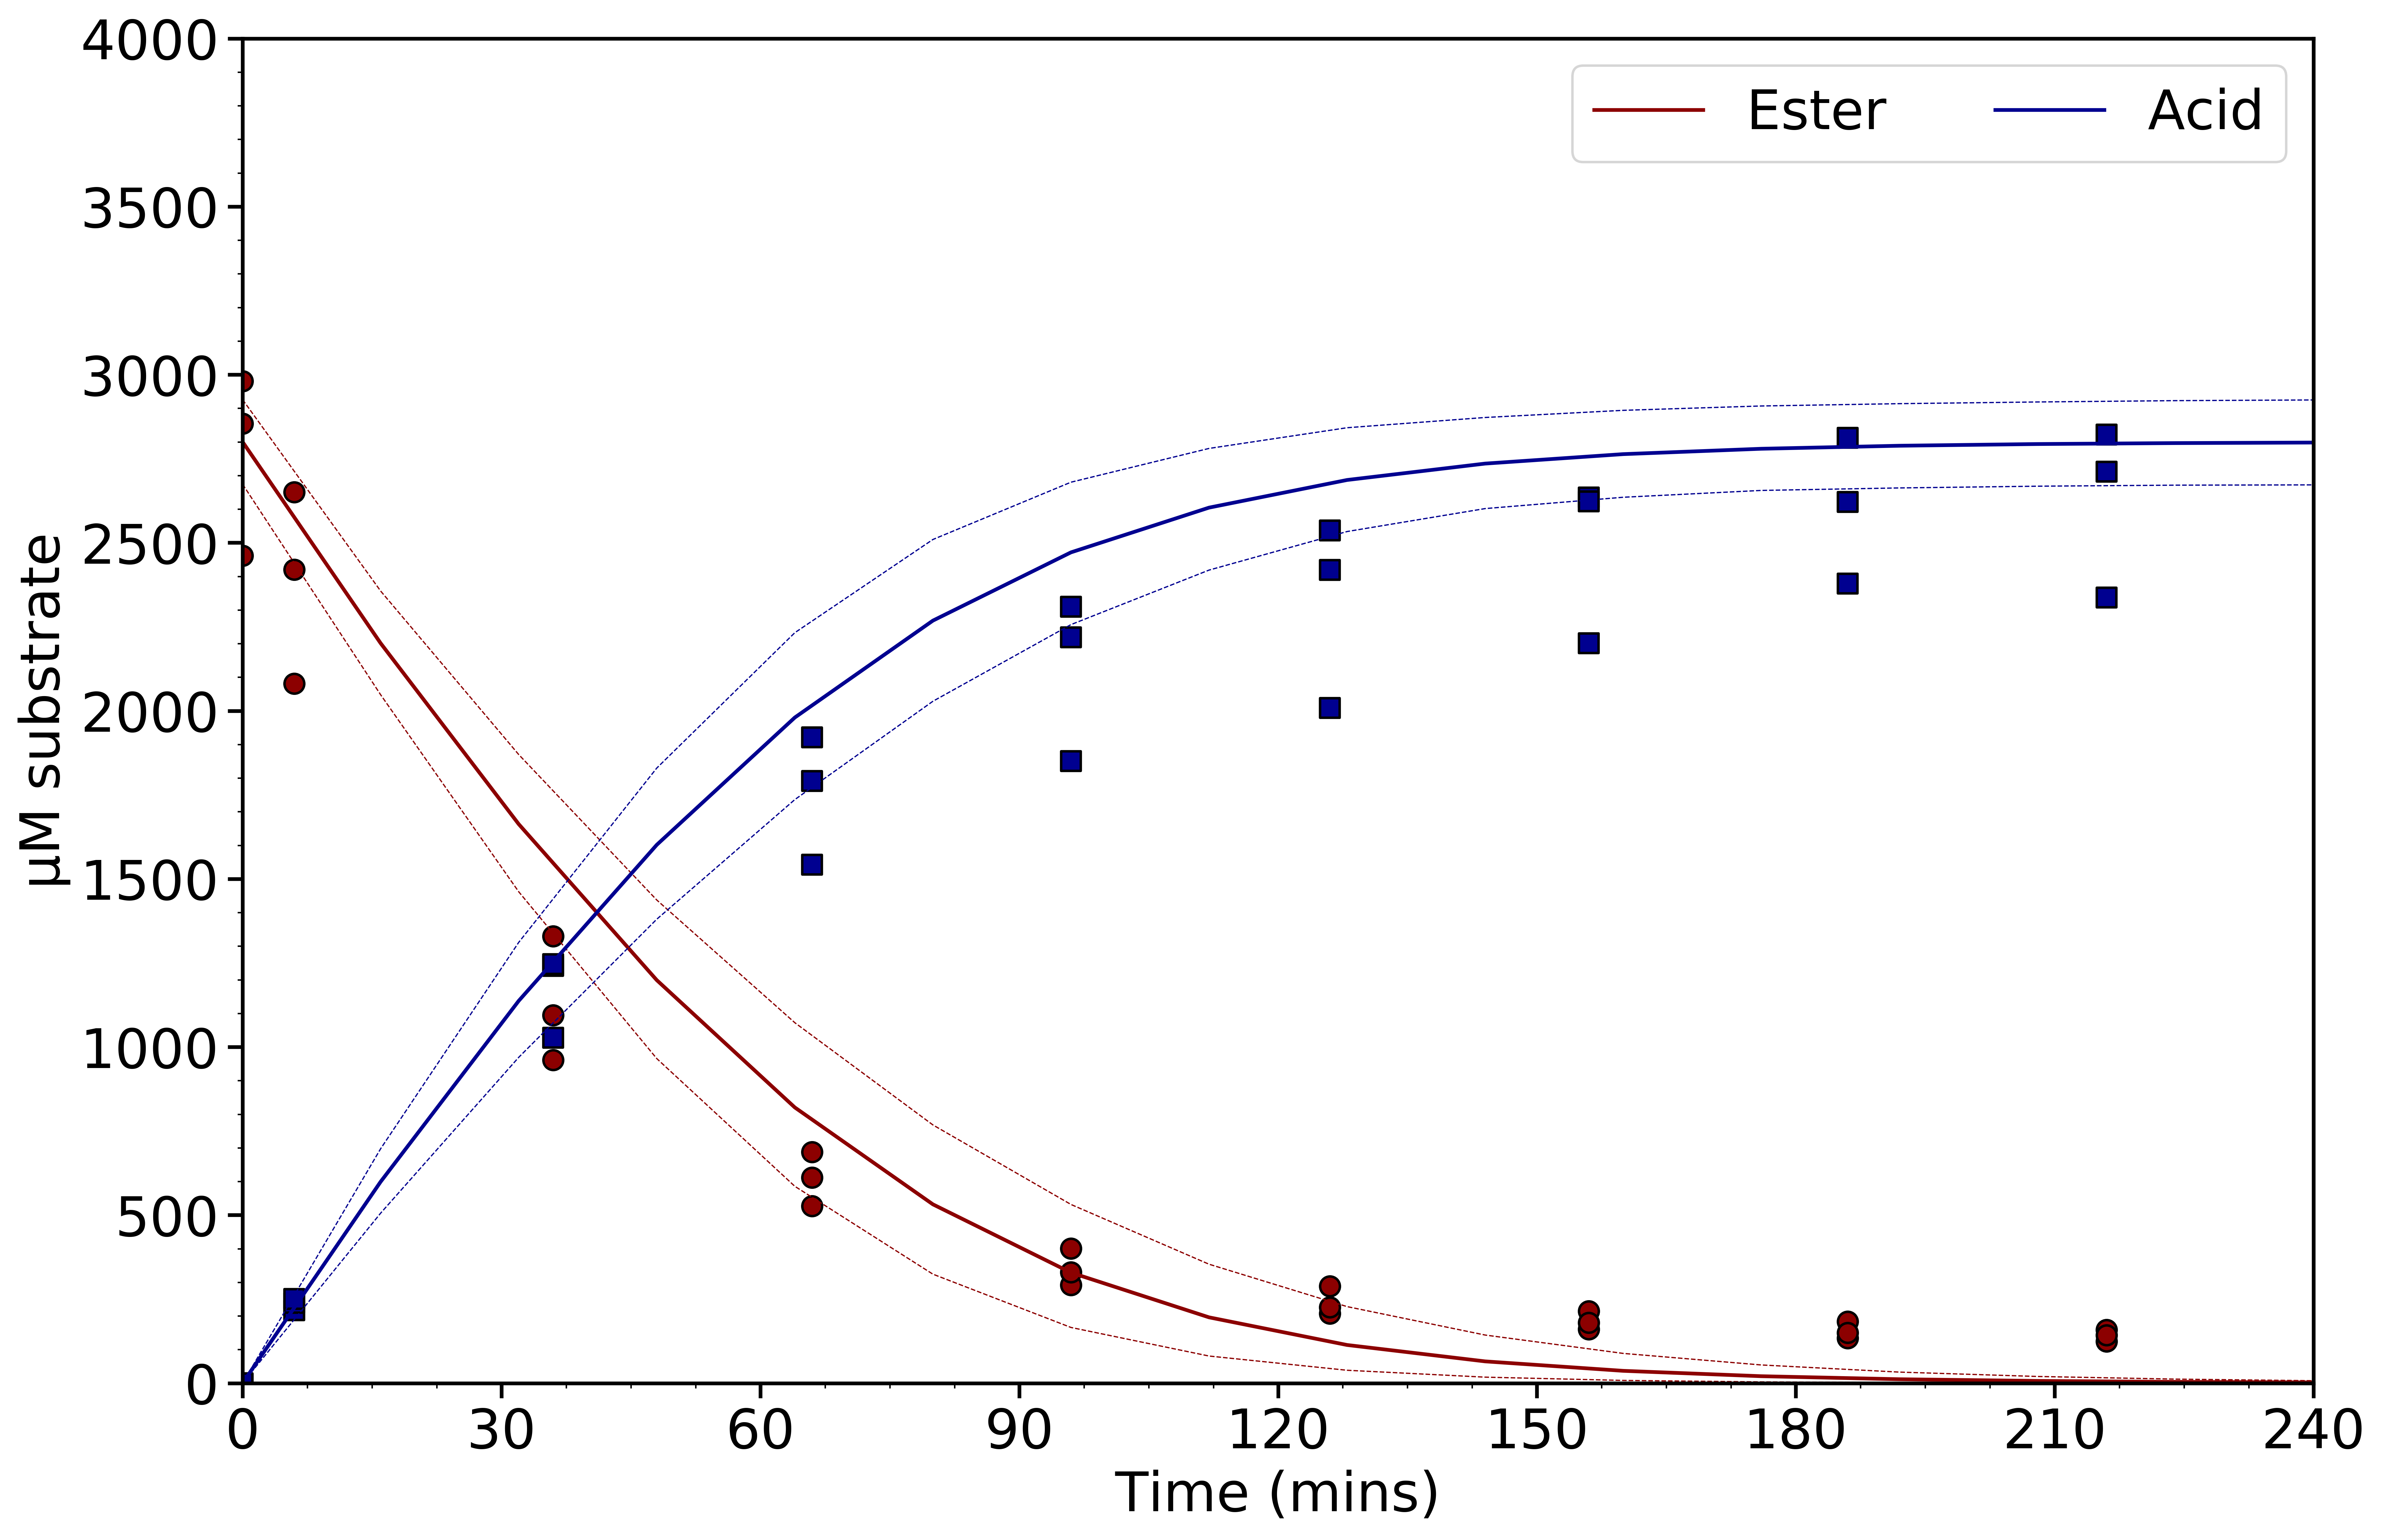

In [5]:
def setup_graph(y_max=4000, x_max=240):
    plt.xlabel('Time (mins)')
    plt.ylabel("μM substrate")
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.minorticks_on()
    plt.xticks(np.arange(0, x_max+1, 30))
    plt.yticks(np.arange(0, y_max+1, 500))
    
    
def add_ua_model_to_graph(substrates_to_add, dataframes):
    
    for substrate in substrates_to_add:
        df = dataframes[substrate]
    
        time = df['Time'].tolist()
        high = df['High'].tolist()
        low = df['Low'].tolist()
        mean = df['Mean'].tolist()
        
        hight_line = plt.plot(time, high, color=substrate_colours[substrate], linestyle="--", linewidth = 0.5)
        low_line = plt.plot(time, low,  color=substrate_colours[substrate], linestyle="--", linewidth = 0.5)
        mean_line = plt.plot(time, mean,  color=substrate_colours[substrate], linewidth = 1.5, label=substrate)
    
        
def add_experimental_data_to_graph(substrates_to_add, exp_data_df):
    time_data = exp_data_df["Time"]
    for substrate in substrates_to_add:
        for column in exp_data_df:
            if substrate in column:
                data_to_plot = exp_data_df[column]
                plt.scatter(time_data, data_to_plot,
                            edgecolors="black",
                            c=substrate_colours[substrate],
                            marker=substrate_symbols[substrate])

        

substrate_colours = {"Ester" : "#8C0000",
                     "Acid" : "#000090",
                     "Aldehyde" : "068400",
                     "Alcohol" : "CA6602"}

substrate_symbols = {"Ester" : "o",
                     "Acid" : "s",
                     "Aldehyde" : "^",
                     "Alcohol" : "v"}


substrates = ["Ester", "Acid"]

set_graph_settings()
setup_graph(y_max=4000, x_max=240)
lines = add_ua_model_to_graph(substrates, ua.substrate_dataframes)
plt.legend(ncol=4)
add_experimental_data_to_graph(substrates, exp_data)

plt.show()

# Information on the uncertainty analysis parameters

In [6]:
info = ua.return_ua_info()
print(info)

--- Species Defaults in Reaction --- 
Ester : 2800
afEst2 : 10

 ---Species Concentration bounds--- 
Ester : (2660.0, 2940.0)
afEst2 : (9.5, 10.5)

--- Parameters Defaults--- 
afest_km_ester : 1500
afest_kcat : 6

--- Parameters Bounds--- 
afest_km_ester : (1300, 1700)
afest_kcat : (5, 7)

Quartile range = 95%
Number of samples = 1000

2 parameters and 2 species in uncertainty analysis
4 variables in total
4^2 = 16
4^3 = 64
1000 samples made by lhc



# Run the sensitivity analysis

In [7]:
timepoint_for_analysis = 240
substrate_for_analysis = "Acid"

sa = kinetics.SA(parameter_bounds,
                 species_bounds,
                 model,
                 number_samples=500,
                 second_order=False,
                 conf_level=0.95,
                 num_resample=100)

sa.make_saltelli_samples()
sa.run_models()
sa.analyse_sobal_sensitivity_substrate_concentration_at_t(timepoint_for_analysis,
                                                          substrate_for_analysis)

display(sa.dataframe_output)

100%|██████████| 3000/3000 [00:04<00:00, 622.80it/s]

Saved as dataframe in self.dataframe_output


,S1,S1_conf,ST,ST_conf
afest_km_ester,0.000119,0.002334,0.000269,0.000066
afest_kcat,0.000850,0.002764,0.000537,0.000087
Ester,0.992760,0.093299,0.992141,0.082300
afEst2,0.000173,0.000930,0.000075,0.000023


# Plot the sensitivity analysis

<function matplotlib.pyplot.show>

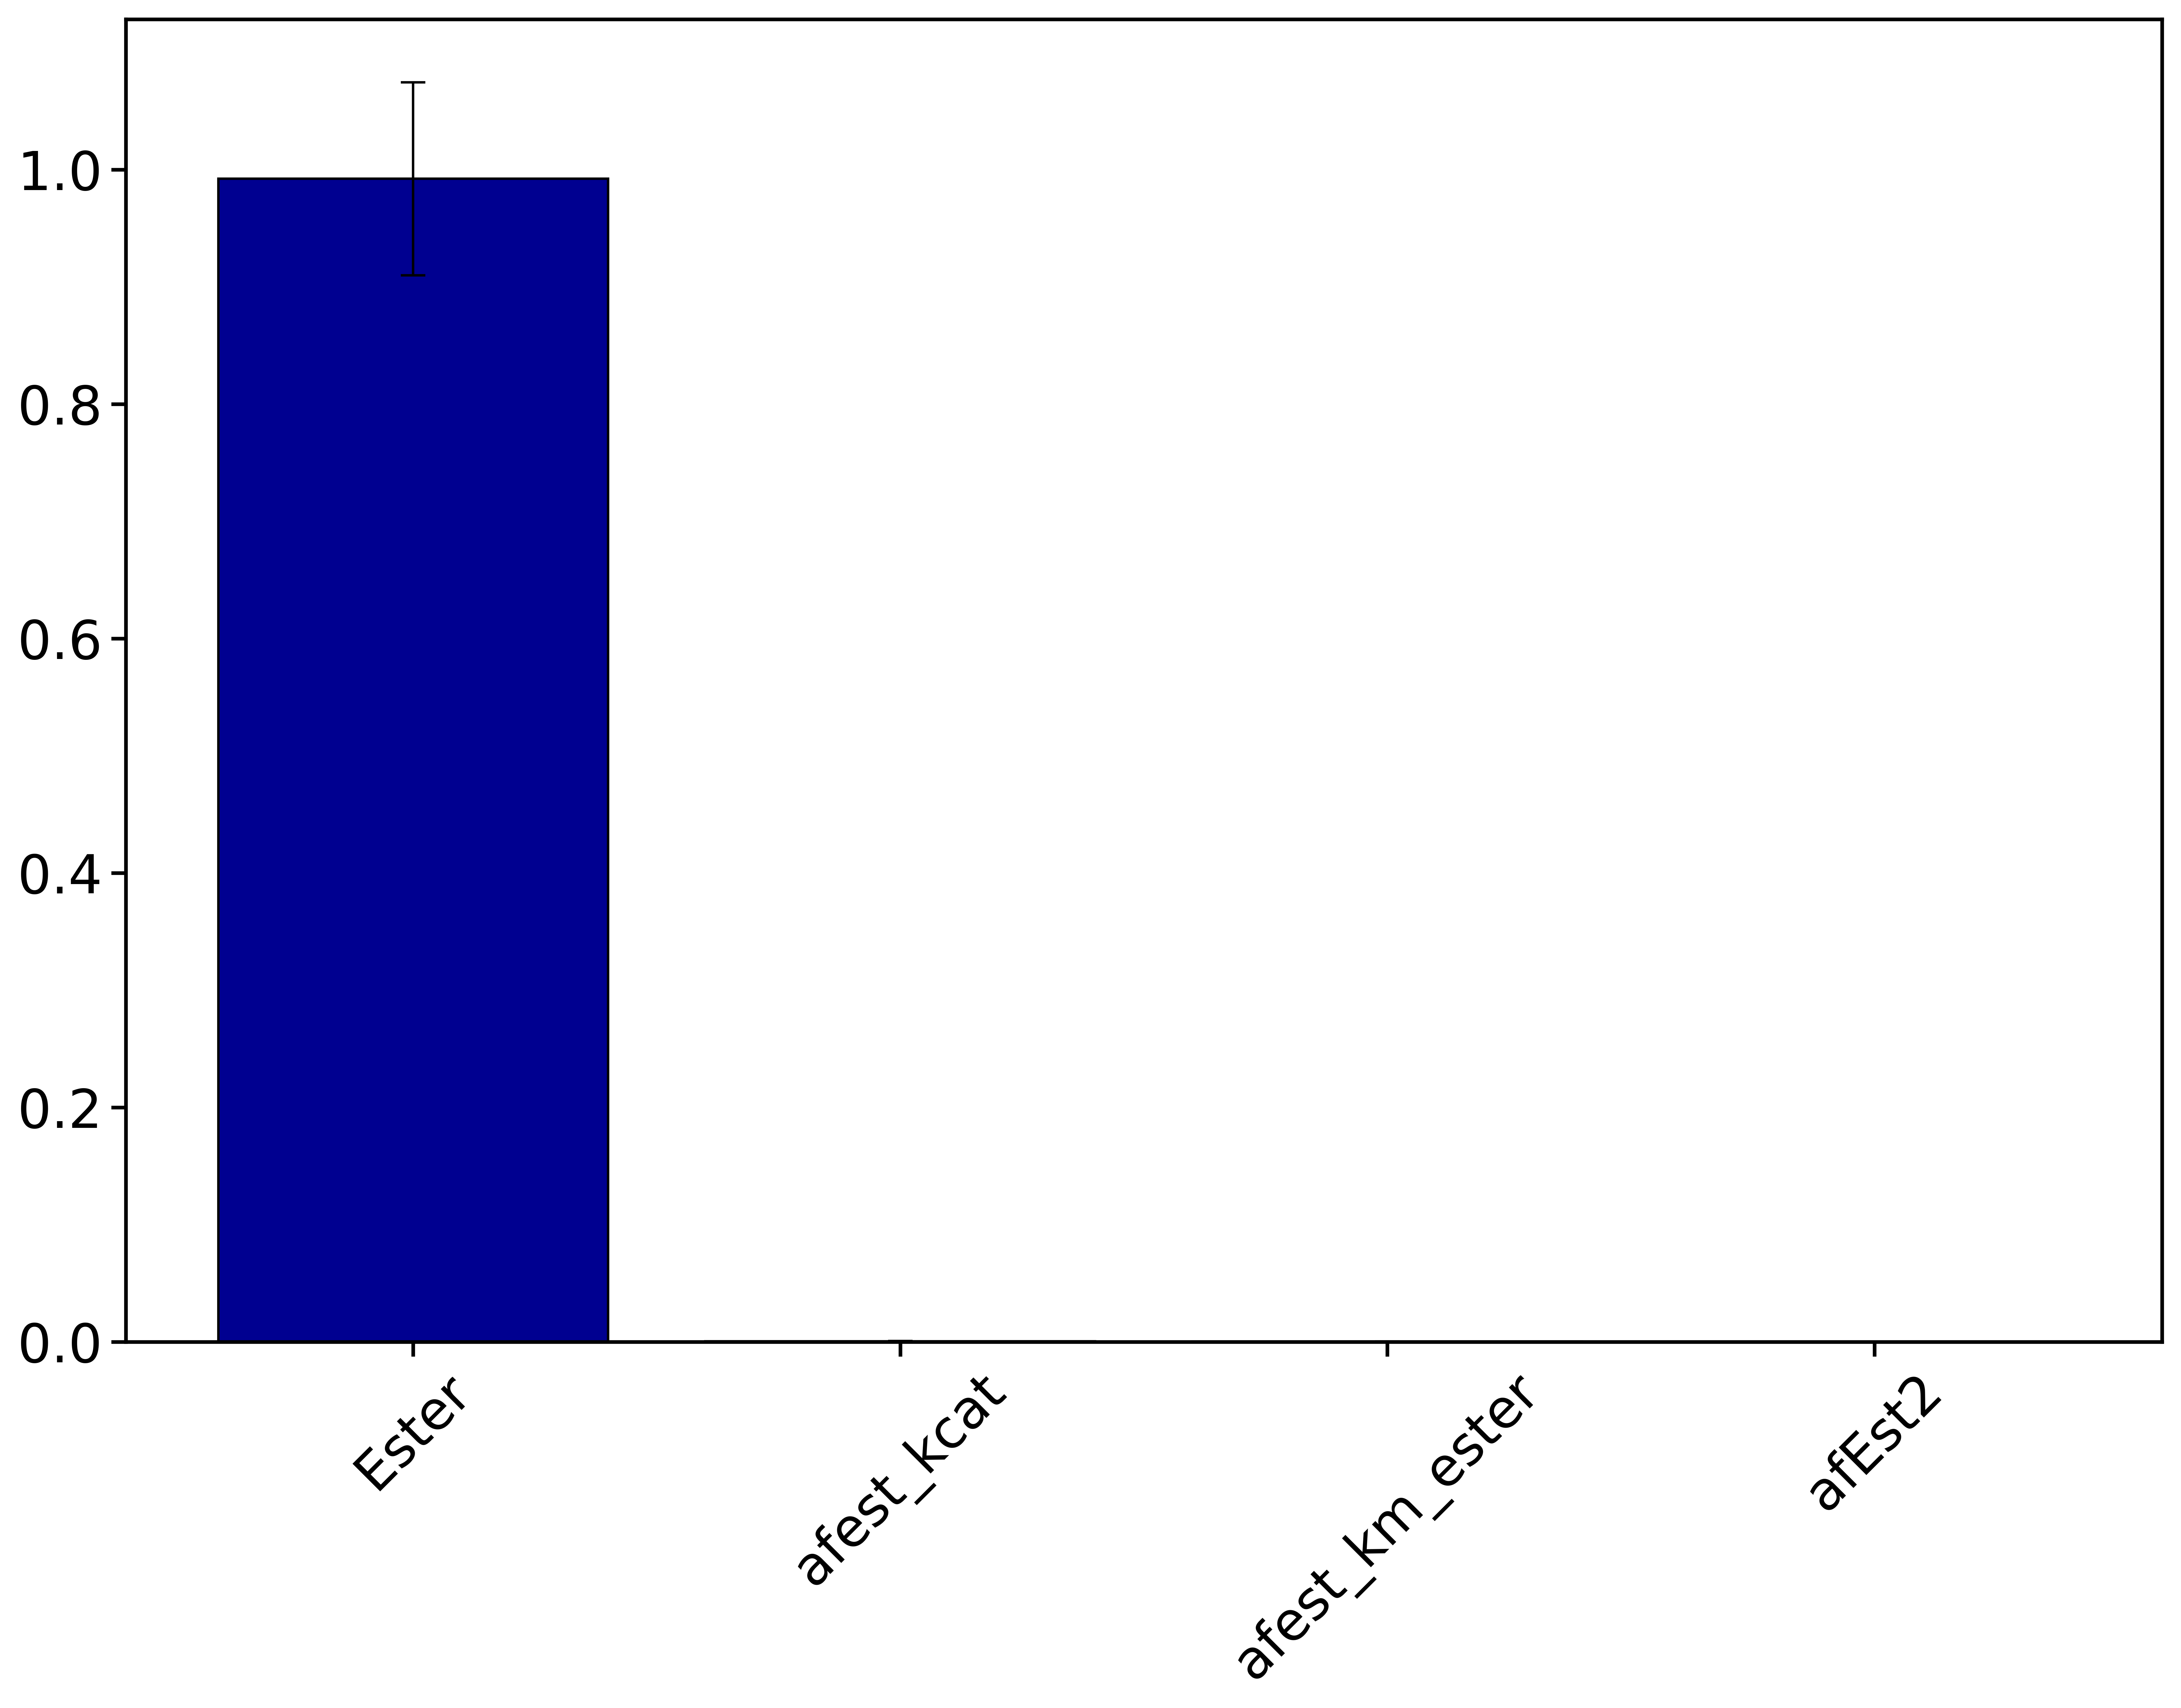

In [8]:
def plot_sa_total_sensitivity(df):
    df.sort_values("ST", inplace=True, ascending=False)

    x_names = df.index.values
    x=np.arange(len(x_names))
    st = df['ST']
    st_err = df['ST_conf']

    plt.bar(x, st, align='center', yerr=st_err, edgecolor='black', color='#000090')
    plt.xticks(x, x_names, rotation=45)
    

plot_sa_total_sensitivity(sa.dataframe_output)
plt.show

# Sensitivity analysis information

In [9]:
info = sa.return_sa_info()
print(info)

---Species concentration bounds--- 
Ester : (2660.0, 2940.0)
afEst2 : (9.5, 10.5)

--- Parameters --- 
afest_km_ester : (1300, 1700)
afest_kcat : (5, 7)

 --- Analysis mode = Uncertainty in substrate at timepoint --- 
Timepoint = 240
Substrate = Acid

 95 % Quartiles at t = 2672.097057681779 : 2923.658341501302
Min at t = 2654.6004761244512,  Max at t = 2939.330126227237

